In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [2]:
%load_ext autoreload
%autoreload 2

import os 
import datetime

import matplotlib
from matplotlib import rc, pyplot
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple


import numpy as np
import torch

import experiments.utils as utils

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
def dsw(list_, max_window_size=4):
    
    start = 0
    window_size = 1
    results = []
    mean = lambda x: sum(x) / len(x)

    while True:
        
        if start+window_size > len(list_):
            if start == len(list_): break
            results.append(round(mean(list_[start:]), 6))
            break
        else:
            results.append(round(mean(list_[start:start+window_size]), 6))
        start = start+window_size
        
        if window_size < max_window_size:
            window_size += 1
            
    return results


# def load_results(dataset_name: str, model_name: str, scale: int, batch_size: int, epochs: int, optimizer: str, lr: float, seed: int) -> dict:
    
#     results_path = os.getenv("RESULTS_DIR_OLD")
#     directory = f"{results_path}/DNN/{dataset_name}/{model_name}/scale_{scale}/bs_{batch_size}" \
#         f"/epochs_{epochs}/{optimizer}/lr_{lr}/seed_{seed}"
    
#     assert os.path.exists(directory), f"Results f{directory} do not exist."
    
#     results = torch.load(f"{directory}/summary.pth", map_location=torch.device('cpu'))
#     return results 

In [4]:
def plotter(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None, linestyles=None, 
            linewidths=None, markers=None, suptitle=None, ylim2=None, prefix="test",
            threshold=1e-10, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    if scales is None:
        scales = [0 for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers):
        hist_all = []
        for seed in range(5):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)

        ## TRAIN LOSS
        train_loss = [x[f"train/epoch/loss"] for x in hist_all]

        mean_line = np.mean(train_loss, axis=0)
        max_line = np.max(train_loss, axis=0)
        min_line = np.min(train_loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(train_loss[0]), len(train_loss[0]) // 10)][:-1]

        ax[0].fill_between(x, max_line, min_line, color=color, alpha=0.2) 
        ax[0].semilogy(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery)
            
        
        ## TEST LOSS
        test_loss = [x[f"test/loss"] for x in hist_all]

        mean_line = np.mean(test_loss, axis=0)
        max_line = np.max(test_loss, axis=0)
        min_line = np.min(test_loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(test_loss[0]), len(test_loss[0]) // 10)][:-1]

        ax[1].fill_between(x, max_line, min_line, color=color, alpha=0.2) 
        ax[1].semilogy(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery)
        
        
        ## TEST ACCURACY
        acc = [x[f"test/acc"] for x in hist_all]
        
        mean_line = np.mean(acc, axis=0)
        max_line = np.max(acc, axis=0)
        min_line = np.min(acc, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(acc[0]), len(acc[0]) // 10)][:-1]

        ax[2].fill_between(x, max_line, min_line, color=color, alpha=0.2) 
        ax[2].plot(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery, label=label)
    
    
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Train Loss", fontsize=14)
        
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Test Loss", fontsize=14)
    
    ax[2].set_xlabel("Epochs", fontsize=14)
    ax[2].set_ylabel("Test Accuracy", fontsize=14)
    
    if ylim2 is not None:
        ax[2].set_ylim(bottom=ylim2[0], top=ylim2[1])
    

    fig.legend()
    
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show() 

In [46]:
def plot_loss(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None, linestyles=None, 
            linewidths=None, markers=None, markersizes=None, suptitle=None, ylabel="Test Loss",
            threshold=1e-10, tight_layout=True, filename=None):
    
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    if markersizes is None:
        markersizes = [7.0 for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker, ms in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers, markersizes):
        hist_all = []
        for seed in range(5):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)
            
        loss = [x["test/loss"] for x in hist_all]
        
        mean_line = np.mean(loss, axis=0)
        max_line = np.max(loss, axis=0)
        min_line = np.min(loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(loss[0]), len(loss[0]) // 10)][:-1]
        
        if scale == 0:
            label = f"{label:<10} (original data)"
        elif scale > 0:
            label = f"{label:<10} (scaled data)  "

        plt.fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        plt.semilogy(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery, markersize=ms, label=label)
        
        
        
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(f"{ylabel}", fontsize=14)

    plt.legend()
    
    plt.grid()
    
    if tight_layout:
        plt.tight_layout()
        
    if filename is not None:

        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(directory + "/" + filename)
    else:
        plt.show() 

In [115]:
def plot_acc(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None, linestyles=None, 
            linewidths=None, markers=None, suptitle=None,
            prefix="test", ylabel="Test Loss", ylim=None,
            seeds: int = 5,
            threshold=1e-10, tight_layout=True, filename=None):
    
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers):
        hist_all = []
        for seed in range(seeds):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)
            
        acc = [x[f"{prefix}"] for x in hist_all]
        
        mean_line = np.mean(acc, axis=0)
        max_line = np.max(acc, axis=0)
        min_line = np.min(acc, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(acc[0]), len(acc[0]) // 10)][:-1]

        plt.fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        plt.plot(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery, label=label)
        
        
        
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(f"{ylabel}", fontsize=14)
    
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    

    plt.legend()
    
    plt.grid()
    
    if tight_layout:
        plt.tight_layout()
        
    if filename is not None:

        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(directory + "/" + filename)
        plt.savefig(directory + "/" + filename)
    else:
        plt.show() 

In [114]:
def plot_all(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None, linestyles=None, 
            linewidths=None, markers=None, suptitle=None,
            postfix="acc", ylabel="Test Loss", ylim=None,
            seeds: int = 5,
            threshold=1e-10, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers):
        hist_all = []
        for seed in range(seeds):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)
            
        train_loss = [x[f"train/epoch/loss"] for x in hist_all]
        
        mean_line = np.mean(train_loss, axis=0)
        max_line = np.max(train_loss, axis=0)
        min_line = np.min(train_loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(train_loss[0]), len(train_loss[0]) // 10)][:-1]

        ax[0].fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        ax[0].plot(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery)
        
        
        test_loss = [x[f"test/epoch/loss"] for x in hist_all]
        
        mean_line = np.mean(test_loss, axis=0)
        max_line = np.max(test_loss, axis=0)
        min_line = np.min(test_loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        ax[1].fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        ax[1].plot(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery)
        
        
        acc = [x[f"test/epoch/{postfix}"] for x in hist_all]
        
        mean_line = np.mean(acc, axis=0)
        max_line = np.max(acc, axis=0)
        min_line = np.min(acc, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])

        ax[2].fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        ax[2].plot(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery, label=label)
        
    
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Train Loss", fontsize=14)
    
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Test Loss", fontsize=14)
        
    ax[2].set_xlabel("Epochs", fontsize=14)
    if postfix == "acc":
        ax[2].set_ylabel("Test Accuracy", fontsize=14)
    elif postfix == "top3_acc":
        ax[2].set_ylabel("Test Top-3 Accuracy", fontsize=14)
    
    if ylim is not None:
        ax[0].set_ylim(bottom=ylim[0][0], top=ylim[0][1])
        ax[1].set_ylim(bottom=ylim[1][0], top=ylim[1][1])
        ax[2].set_ylim(bottom=ylim[2][0], top=ylim[2][1])
    

    fig.legend()
    
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(directory + "/" + filename)
        plt.savefig(directory + "/" + filename)
    else:
        plt.show() 

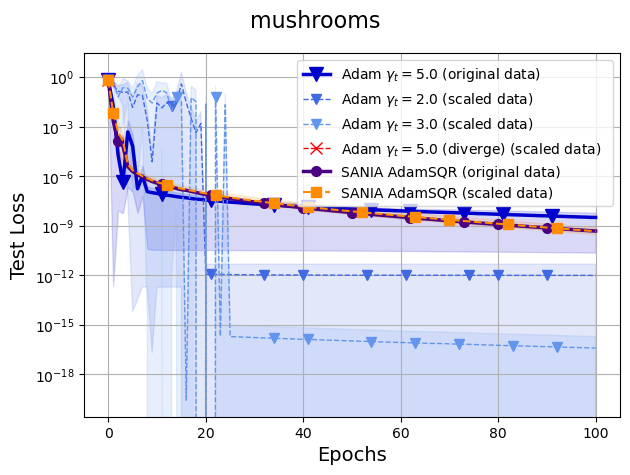

In [50]:
dataset_name = "mushrooms"
model_name = "linear"
batch_size = 128
n_epochs = 100

methods = ["Adam", "Adam", "Adam", "Adam"]
lrs = [5.0, 2.0, 3.0, 5.0]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdamSQR", "SANIA_AdamSQR"]
labels += ["SANIA AdamSQR", "SANIA AdamSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", "-", "--"]
markers = ["v", "v", "v", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["mediumblue", "royalblue", "cornflowerblue", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += " (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )


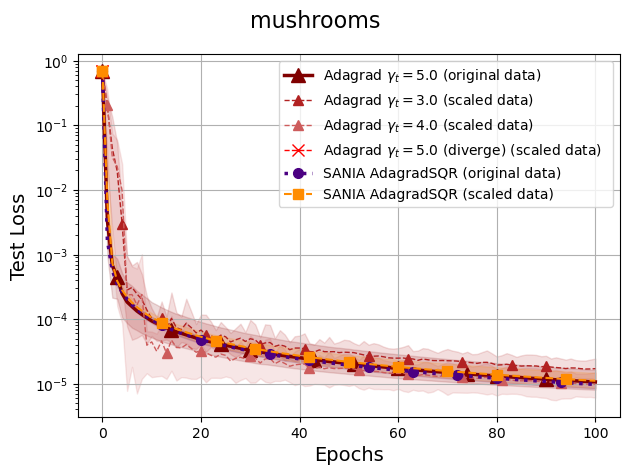

In [51]:
dataset_name = "mushrooms"
model_name = "linear"
batch_size = 128
n_epochs = 100

methods = ["Adagrad", "Adagrad", "Adagrad", "Adagrad"]
lrs = [5.0, 3.0, 4.0, 5.0]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdagradSQR", "SANIA_AdagradSQR"]
labels += ["SANIA AdagradSQR", "SANIA AdagradSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", ":", "--"]
markers = ["^", "^", "^", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["maroon", "firebrick", "indianred", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += r" (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

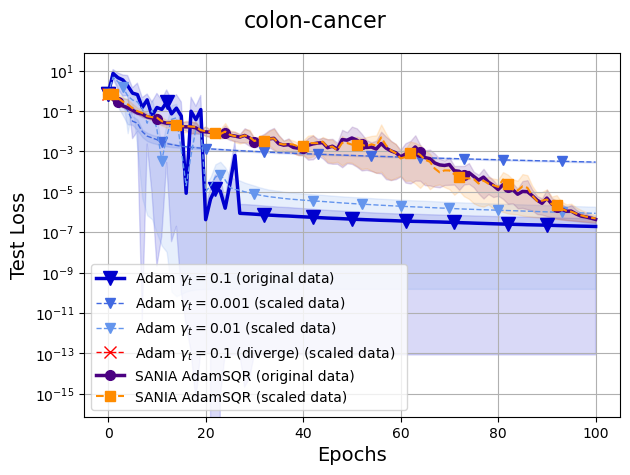

In [58]:
dataset_name = "colon-cancer"
model_name = "linear"
batch_size = 8
n_epochs = 100

methods = ["Adam", "Adam", "Adam", "Adam"]
lrs = [0.1, 0.001, 0.01, 0.1]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdamSQR", "SANIA_AdamSQR"]
labels += ["SANIA AdamSQR", "SANIA AdamSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", "-", "--"]
markers = ["v", "v", "v", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["mediumblue", "royalblue", "cornflowerblue", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += " (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )


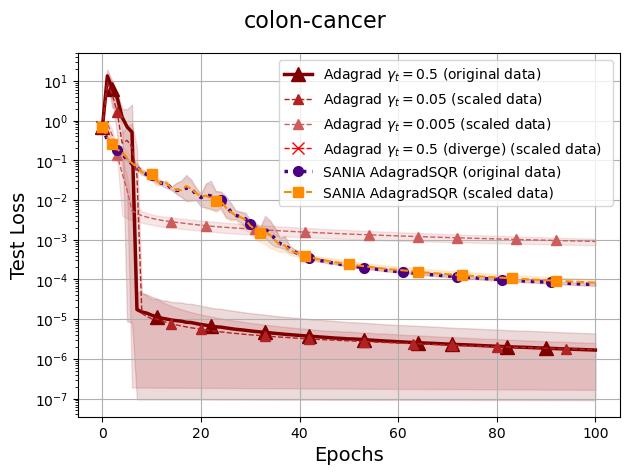

In [60]:
dataset_name = "colon-cancer"
model_name = "linear"
batch_size = 8
n_epochs = 100

methods = ["Adagrad", "Adagrad", "Adagrad", "Adagrad"]
lrs = [0.5, 0.05, 0.005, 0.5]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdagradSQR", "SANIA_AdagradSQR"]
labels += ["SANIA AdagradSQR", "SANIA AdagradSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", ":", "--"]
markers = ["^", "^", "^", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["maroon", "firebrick", "indianred", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += r" (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

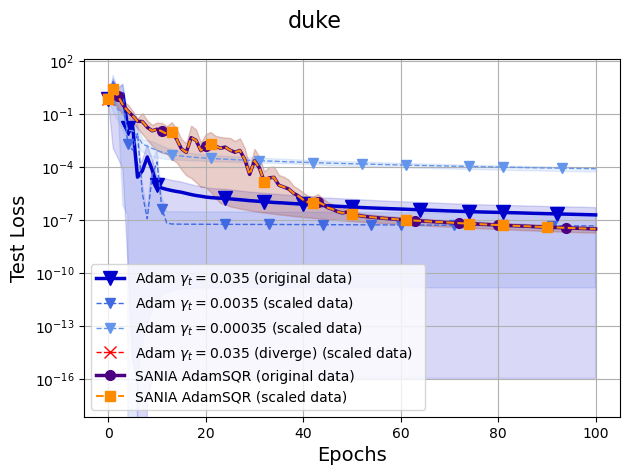

In [63]:
dataset_name = "duke"
model_name = "linear"
batch_size = 8
n_epochs = 100

methods = ["Adam", "Adam", "Adam", "Adam"]
lrs = [0.035, 0.0035, 0.00035, 0.035]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdamSQR", "SANIA_AdamSQR"]
labels += ["SANIA AdamSQR", "SANIA AdamSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", "-", "--"]
markers = ["v", "v", "v", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["mediumblue", "royalblue", "cornflowerblue", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += " (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )


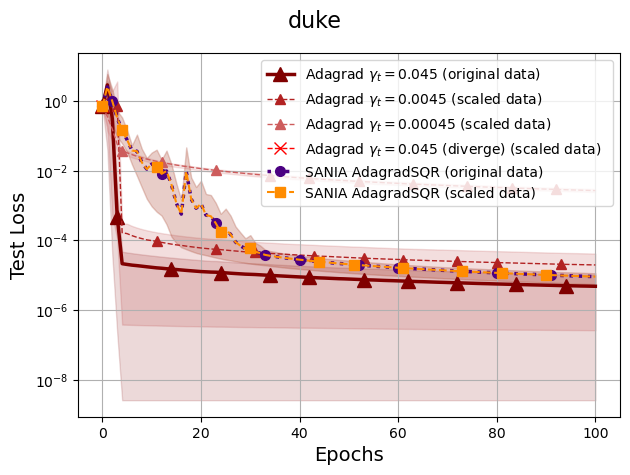

In [65]:
dataset_name = "duke"
model_name = "linear"
batch_size = 8
n_epochs = 100

methods = ["Adagrad", "Adagrad", "Adagrad", "Adagrad"]
lrs = [0.045, 0.0045, 0.00045, 0.045]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdagradSQR", "SANIA_AdagradSQR"]
labels += ["SANIA AdagradSQR", "SANIA AdagradSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", ":", "--"]
markers = ["^", "^", "^", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["maroon", "firebrick", "indianred", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

labels[3] += r" (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

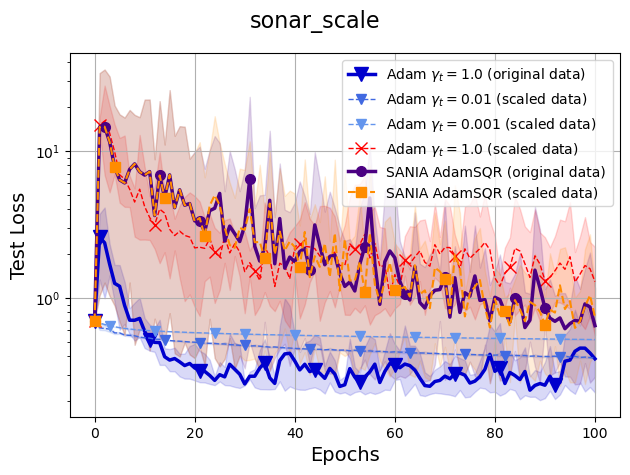

In [69]:
dataset_name = "sonar_scale"
model_name = "linear"
batch_size = 64
n_epochs = 100

methods = ["Adam", "Adam", "Adam", "Adam"]
lrs = [1.0, 0.01, 0.001, 1.0]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdamSQR", "SANIA_AdamSQR"]
labels += ["SANIA AdamSQR", "SANIA AdamSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", "-", "--"]
markers = ["v", "v", "v", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["mediumblue", "royalblue", "cornflowerblue", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

# labels[3] += " (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )


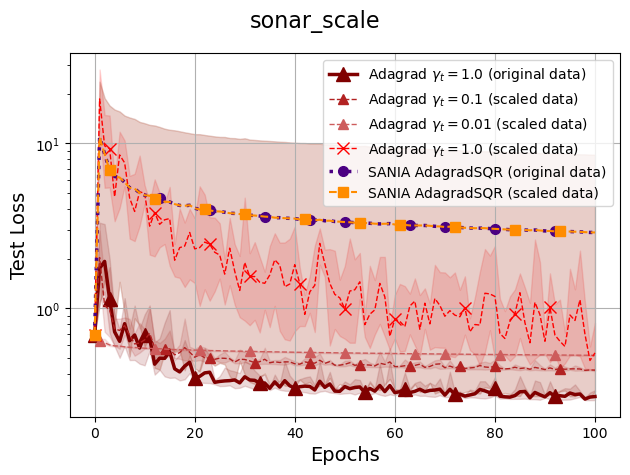

In [71]:
dataset_name = "sonar_scale"
model_name = "linear"
batch_size = 64
n_epochs = 100

methods = ["Adagrad", "Adagrad", "Adagrad", "Adagrad"]
lrs = [1.0, 0.1, 0.01, 1.0]
labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]

methods  += ["SANIA_AdagradSQR", "SANIA_AdagradSQR"]
labels += ["SANIA AdagradSQR", "SANIA AdagradSQR"]
lrs += [1.0, 1.0]

scales = [0, 4, 4, 4, 0, 4]
linestyles = ["-", "--", "--", "--", ":", "--"]
markers = ["^", "^", "^", "x", "o", "s"]
markersizes = [10.0, 7.0, 7.0, 8.0, 7.0, 7.0]
colors = ["maroon", "firebrick", "indianred", "red", "indigo", "darkorange"]
linewidths = [2.5, 1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name

# labels[3] += r" (diverge)"

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, markersizes=markersizes, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

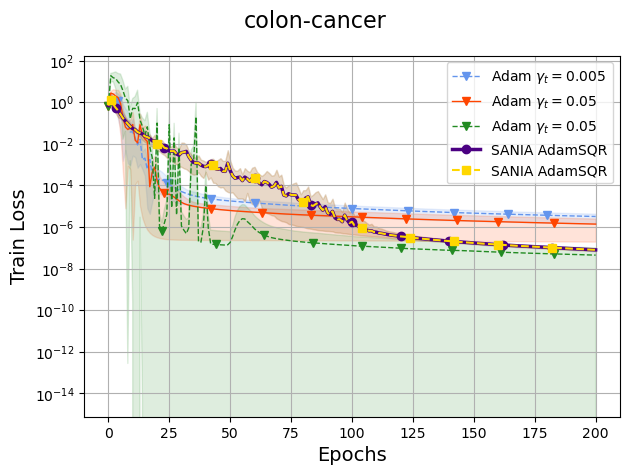

In [27]:
dataset_name = "colon-cancer"
model_name = "linear"
batch_size = 16
n_epochs = 200

methods = ["Adam", "Adam", "Adam", "SANIA_AdamSQR", "SANIA_AdamSQR"]
lrs = [0.005, 0.05, 0.05, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
linewidths = [1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adam $\gamma_t = 0.005$", r"Adam $\gamma_t = 0.05$", r"Adam $\gamma_t = 0.05$", "SANIA AdamSQR", "SANIA AdamSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Train Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

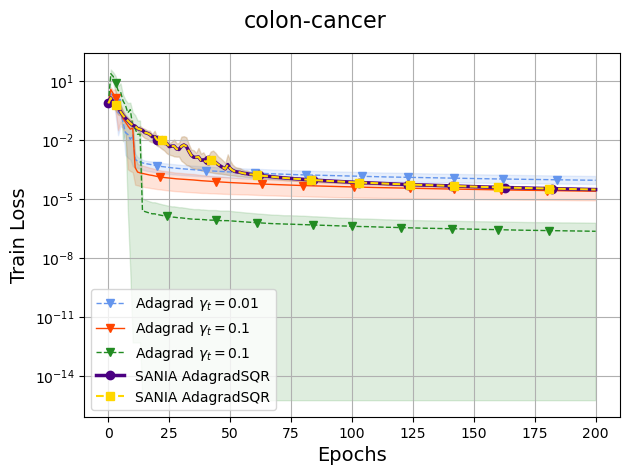

In [28]:
dataset_name = "colon-cancer"
model_name = "linear"
batch_size = 16
n_epochs = 200

methods = ["Adagrad", "Adagrad", "Adagrad", "SANIA_AdagradSQR", "SANIA_AdagradSQR"]
lrs = [0.01, 0.1, 0.1, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
linewidths = [1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adagrad $\gamma_t = 0.01$", r"Adagrad $\gamma_t = 0.1$", r"Adagrad $\gamma_t = 0.1$", "SANIA AdagradSQR", "SANIA AdagradSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Train Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

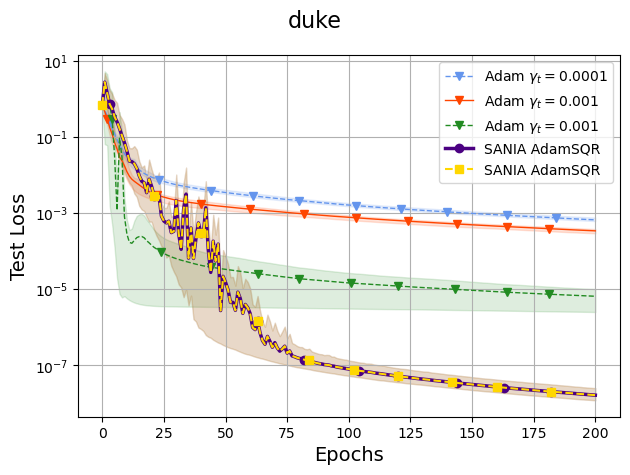

In [29]:
dataset_name = "duke"
model_name = "linear"
batch_size = 16
n_epochs = 200

methods = ["Adam", "Adam", "Adam", "SANIA_AdamSQR", "SANIA_AdamSQR"]
lrs = [0.0001, 0.001, 0.001, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
linewidths = [1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adam $\gamma_t = 0.0001$", r"Adam $\gamma_t = 0.001$", r"Adam $\gamma_t = 0.001$", "SANIA AdamSQR", "SANIA AdamSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Test Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

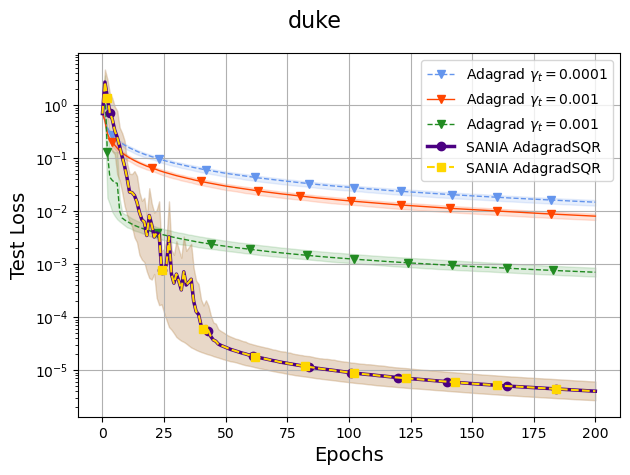

In [30]:
dataset_name = "duke"
model_name = "linear"
batch_size = 16
n_epochs = 200

methods = ["Adagrad", "Adagrad", "Adagrad", "SANIA_AdagradSQR", "SANIA_AdagradSQR"]
lrs = [0.0001, 0.001, 0.001, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
linewidths = [1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adagrad $\gamma_t = 0.0001$", r"Adagrad $\gamma_t = 0.001$", r"Adagrad $\gamma_t = 0.001$", "SANIA AdagradSQR", "SANIA AdagradSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Test Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

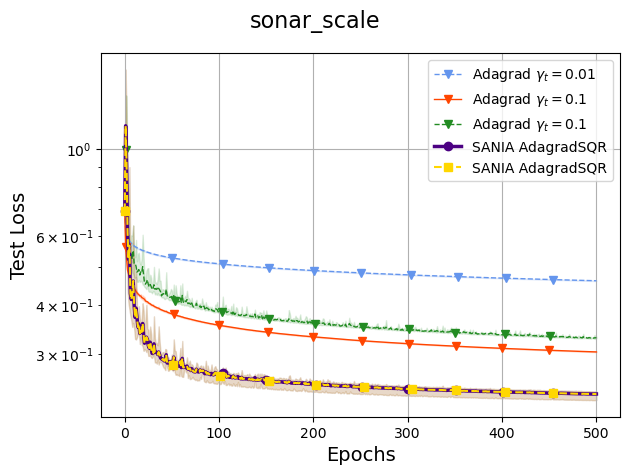

In [31]:
dataset_name = "sonar_scale"
model_name = "linear"
batch_size = 16
n_epochs = 500

methods = ["Adagrad", "Adagrad", "Adagrad", "SANIA_AdagradSQR", "SANIA_AdagradSQR"]
lrs = [0.01, 0.1, 0.1, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
linewidths = [1.0, 1.0, 1.0, 2.5, 1.5]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adagrad $\gamma_t = 0.01$", r"Adagrad $\gamma_t = 0.1$", r"Adagrad $\gamma_t = 0.1$", "SANIA AdagradSQR", "SANIA AdagradSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Test Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

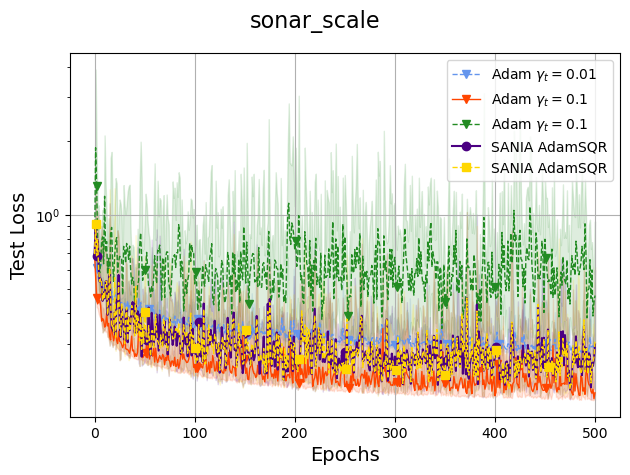

In [32]:
dataset_name = "sonar_scale"
model_name = "linear"
batch_size = 16
n_epochs = 500

methods = ["Adam", "Adam", "Adam", "SANIA_AdamSQR", "SANIA_AdamSQR"]
lrs = [0.01, 0.1, 0.1, 1.0, 1.0]
scales = [4, 0, 4, 0, 4]
linestyles = ["--", "-", "--", "-", "--"]
linewidths = [1.0, 1.0, 1.0, 1.5, 1.0]
markers = ["v", "v", "v", "o", "s"]
colors = ["cornflowerblue", "orangered", "forestgreen", "indigo", "gold"]
suptitle = dataset_name
# labels = [r"{0} $\gamma_t = {1}$".format(method, lr) for method, lr in zip(methods, lrs)]
labels = [r"Adam $\gamma_t = 0.01$", r"Adam $\gamma_t = 0.1$", r"Adam $\gamma_t = 0.1$", "SANIA AdamSQR", "SANIA AdamSQR"]

plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylabel="Test Loss",
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

In [72]:
linear_lrs_dict = {
    "mushrooms": {
        "KATE": {"lr": 1.0, "eta": 1e-3},
        "Adam": {"lr": 1.0},
        "Adagrad": {"lr": 1.0},
        "SGD": {"lr": 1.0},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "a1a": {
        "KATE": {"lr": 0.01, "eta": 1e-3},
        "Adam": {"lr": 0.001},
        "Adagrad": {"lr": 0.1},
        "SGD": {"lr": 1.0},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "australian_scale": {
        "KATE": {"lr": 0.1, "eta": 1e-3},
        "Adam": {"lr": 0.1},
        "Adagrad": {"lr": 0.5},
        "SGD": {"lr": 1.0},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "cod-rna": {
        "KATE": {"lr": 1.0, "eta": 1e-3},
        "Adam": {"lr": 0.01},
        "Adagrad": {"lr": 0.01},
        "SGD": {"lr": 0.00001},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
        
    },
    "breast-cancer_scale": {
        "KATE": {"lr": 0.5, "eta": 1e-3},
        "Adam": {"lr": 0.5},
        "Adagrad": {"lr": 1.0},
        "SGD": {"lr": 1.0},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "gisette_scale": {
        "KATE": {"lr": 0.01, "eta": 1e-3},
        "Adam": {"lr": 0.001},
        "Adagrad": {"lr": 0.01},
        "SGD": {"lr": 0.01},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "leu": {
        "KATE": {"lr": 0.0001, "eta": 1e-3},
        "Adam": {"lr": 0.001},
        "Adagrad": {"lr": 0.001},
        "SGD": {"lr": 0.01},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "madelon": {
        "KATE": {"lr": 0.0001, "eta": 1e-3},
        "Adam": {"lr": 0.0001},
        "Adagrad": {"lr": 0.001},
        "SGD": {"lr": 1e-8},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    },
    "colon-cancer": {
        "KATE": {"lr": 0.1, "eta": 1e-3},
        "Adam": {"lr": 0.1},
        "Adagrad": {"lr": 0.5},
        "SGD": {"lr": 0.5},
        "SANIA_AdamSQR": {"lr": 1.0},
        "SANIA_AdagradSQR": {"lr": 1.0},
    }

}

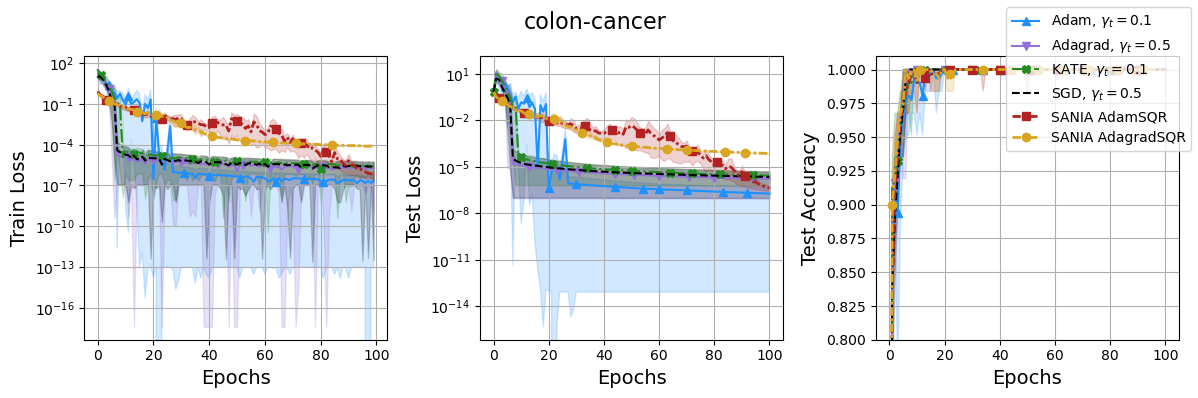

In [113]:
dataset_name = "colon-cancer"
batch_size = 8
n_epochs = 100
model_name = "linear"


methods = ["Adam", "Adagrad", "KATE", "SGD"]
lrs = [linear_lrs_dict[dataset_name][method].get("lr") for method in methods]
labels = [fr"{method}, $\gamma_t = {lr}$" for method, lr in zip(methods, lrs)]

methods += ["SANIA_AdamSQR", "SANIA_AdagradSQR"]
labels += ["SANIA AdamSQR", "SANIA AdagradSQR"]
lrs += [1.0, 1.0]

colors = ["dodgerblue", "mediumpurple", "forestgreen", "black", "firebrick", "goldenrod"]


linestyles = ["-", "-", "-.", "--", (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1))]
linewidths = [1.5, 1.5, 1.5, 1.5, 2.0, 2.0]
markers = ["^", "v", "X", " ", "s", "o"]
suptitle = dataset_name

plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=None, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.8, 1.01],
        filename=f"linear_all_metrics_{dataset_name}_{batch_size}.pdf",
        )

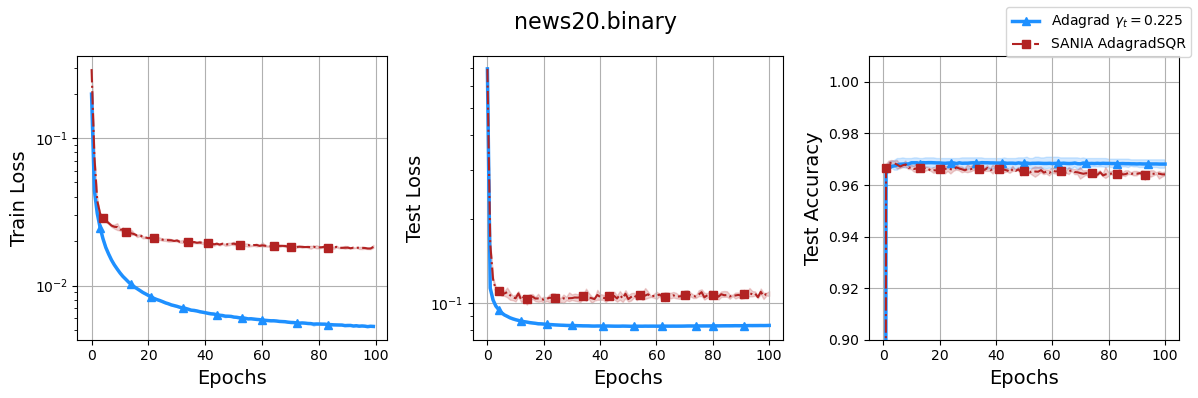

In [26]:
dataset_name = "news20.binary"
batch_size = 256
n_epochs = 100
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [0.225, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 0.225$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "-."]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name

plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.9, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf")

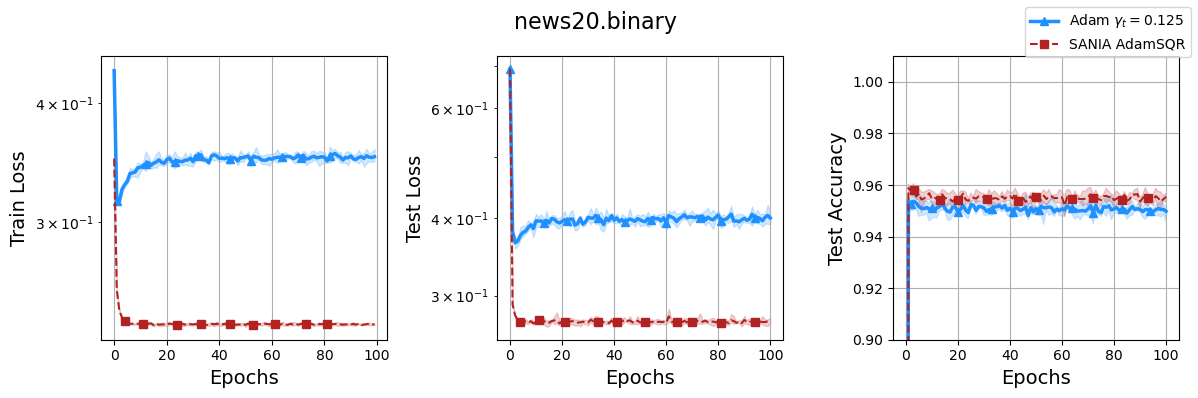

In [27]:
dataset_name = "news20.binary"
batch_size = 256
n_epochs = 100
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.125, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.125$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.9, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

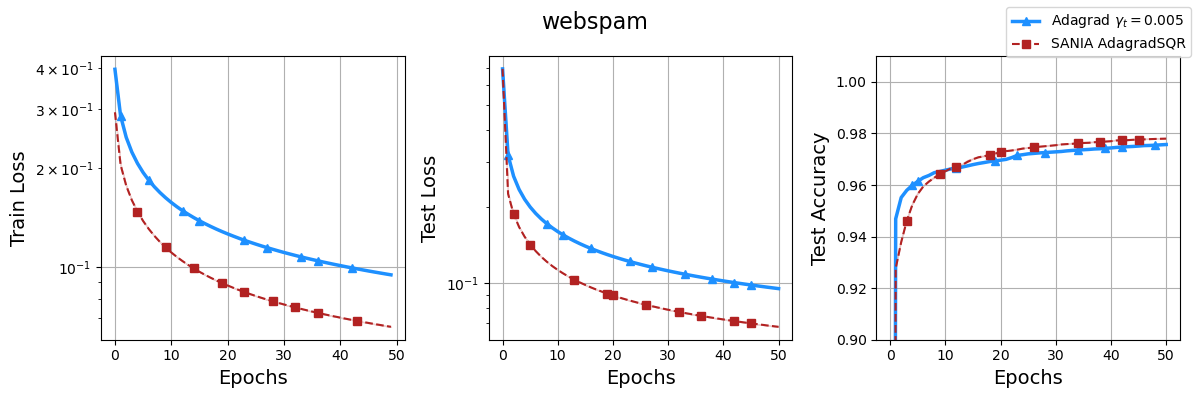

In [28]:
dataset_name = "webspam"
batch_size = 512
n_epochs = 50
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [0.005, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 0.005$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.9, 1.01], 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

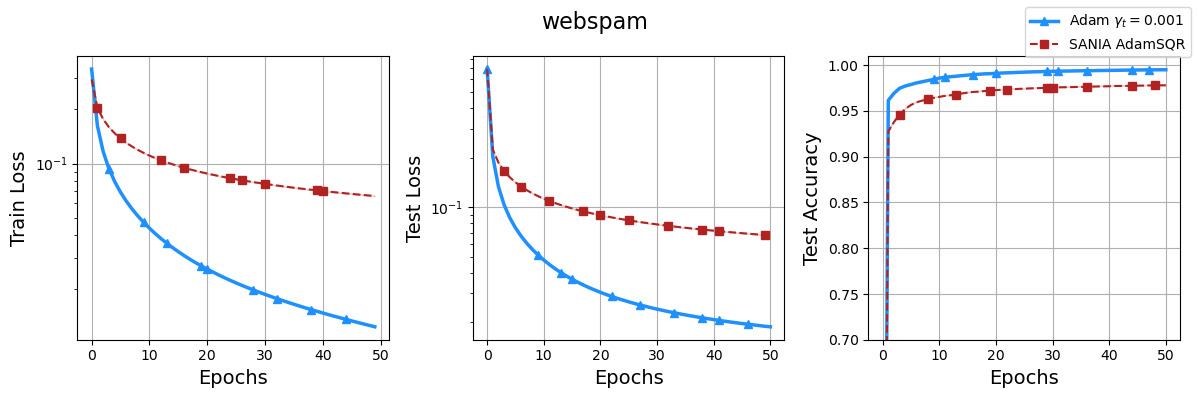

In [29]:
dataset_name = "webspam"
batch_size = 512
n_epochs = 50
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.001, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.001$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.7, 1.01], 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

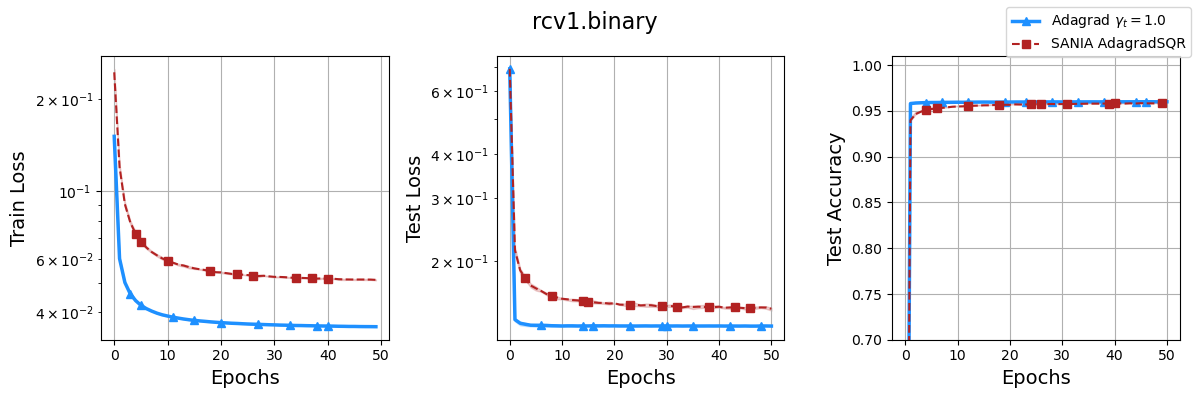

In [31]:
dataset_name = "rcv1.binary"
batch_size = 256
n_epochs = 50
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 1.0$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.7, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

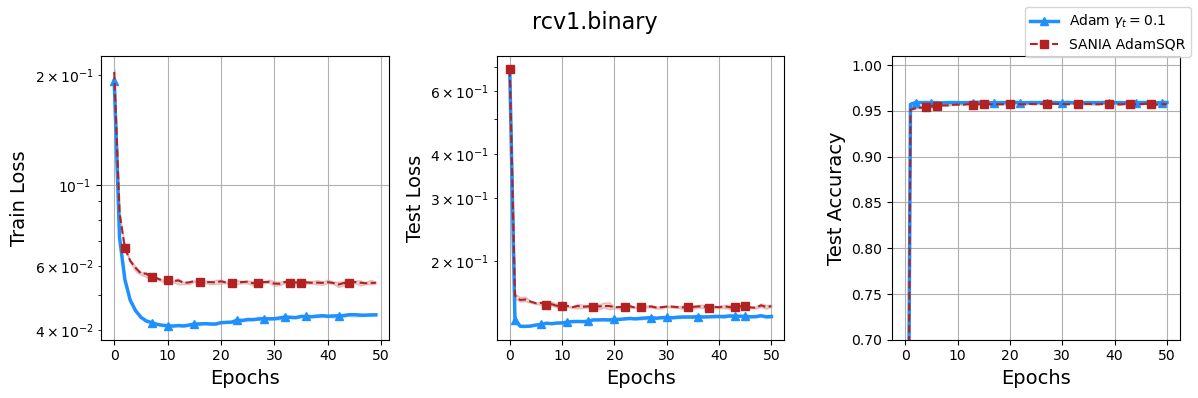

In [32]:
dataset_name = "rcv1.binary"
batch_size = 256
n_epochs = 50
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.1, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.1$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.7, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

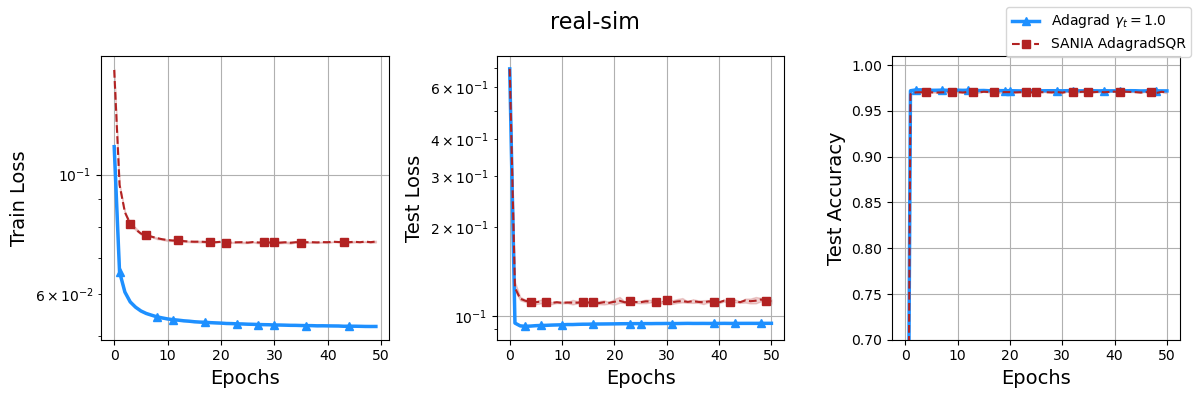

In [33]:
dataset_name = "real-sim"
batch_size = 256
n_epochs = 50
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 1.0$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.7, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

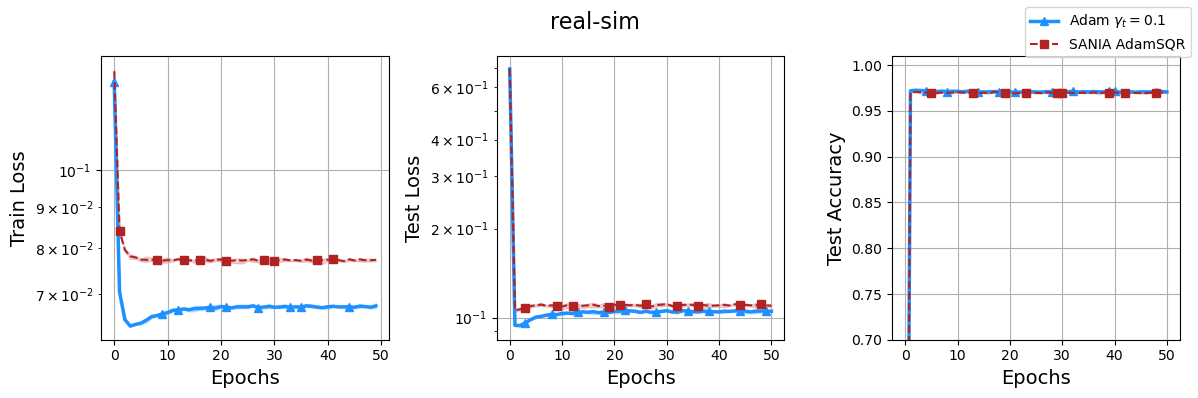

In [34]:
dataset_name = "real-sim"
batch_size = 256
n_epochs = 50
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.1, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.1$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.7, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

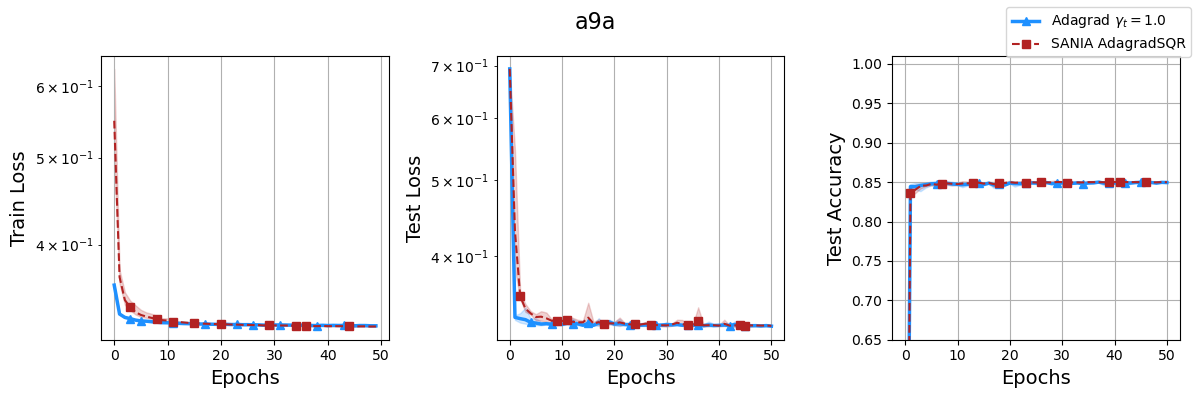

In [35]:
dataset_name = "a9a"
batch_size = 64
n_epochs = 50
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 1.0$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.65, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

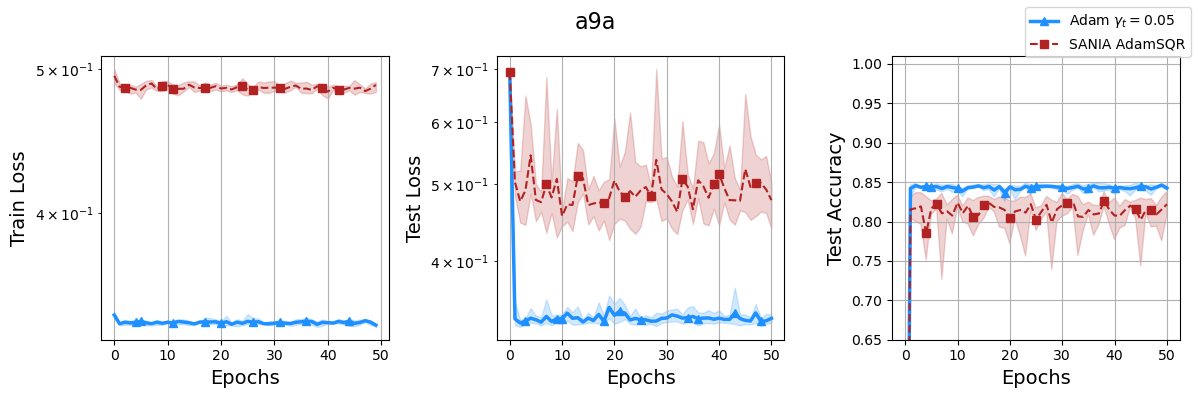

In [36]:
dataset_name = "a9a"
batch_size = 64
n_epochs = 50
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.05, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.05$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.65, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

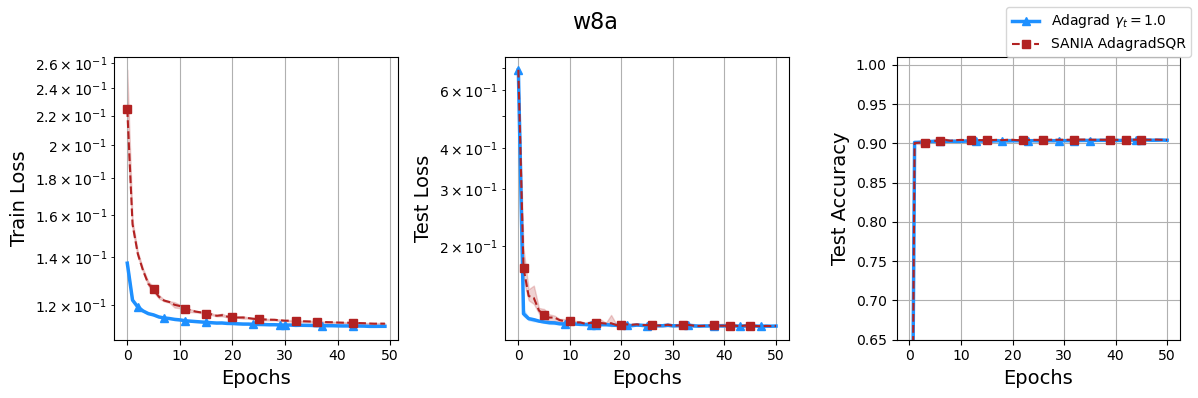

In [37]:
dataset_name = "w8a"
batch_size = 64
n_epochs = 50
model_name = "linear"

methods = ["Adagrad", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0]
scales = [0, 0]
labels = [r"Adagrad $\gamma_t = 1.0$", "SANIA AdagradSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.65, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

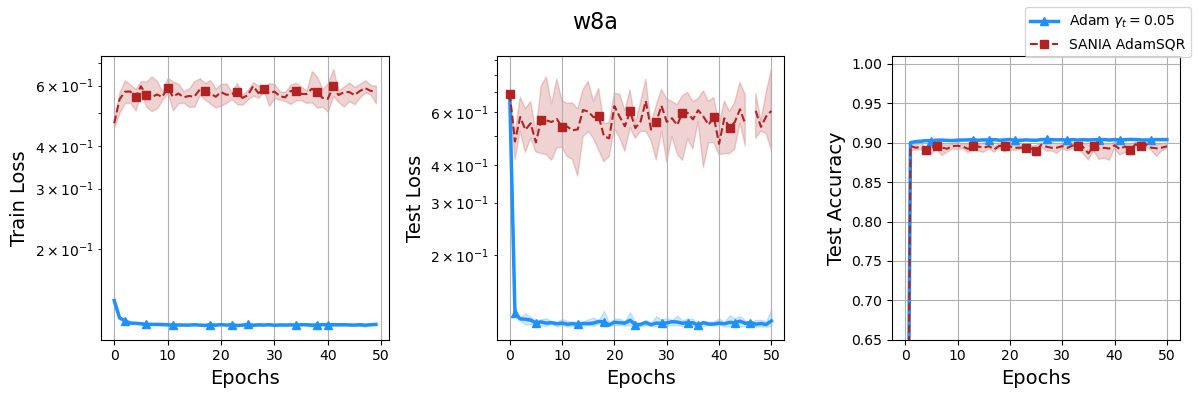

In [38]:
dataset_name = "w8a"
batch_size = 64
n_epochs = 50
model_name = "linear"

methods = ["Adam", "SANIA_AdamSQR"]
lrs = [0.05, 1.0]
scales = [0, 0]
labels = [r"Adam $\gamma_t = 0.05$", "SANIA AdamSQR"]
colors = ["dodgerblue", "firebrick"]
linestyles = ["-", "--"]
linewidths = [2.5, 1.5]
markers = ["^", "s"]
suptitle = dataset_name


plotter(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name,
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles,
        linewidths=linewidths, markers=markers, suptitle=suptitle, ylim2=[0.65, 1.01],
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf"
        )

In [137]:
dataset_name = "MNIST"
model_name = "LeNet5"
batch_size = 32
n_epochs = 100

methods = ["Adam", "SANIA_AdamSQR", "Adagrad", "SANIA_AdagradSQR", "KATE"]
lrs = [0.001, 1.0, 0.01, 1.0, 0.001]
colors = ["dodgerblue", "firebrick", "mediumpurple", "goldenrod", "forestgreen"]
linestyles = ["-", "--", "-", "--", "-"]
linewidths = [2.5, 1.5, 2.5, 1.5, 1.5]
markers = ["^", "s", "v", "o", "X"]
labels = [r"Adam $\gamma_t = 0.001$", "SANIA AdamSQR", r"Adagrad $\gamma_t = 0.01$", "SANIA AdagradSQR", r"KATE $\gamma_t = 0.001$"]

scales = [0, 0, 0, 0, 0]

# plot_all(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         postfix="acc", ylim=[[0.0, 0.1], [0.0, 0.4], [0.97, 1.0]],
#         threshold=0.0, tight_layout=True, 
#         filename=f"all_metrics_{dataset_name}_{model_name}_{batch_size}.pdf"
#         )

# plot_acc(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         prefix="test/epoch/acc", ylim=[0.9, 1.01], ylabel="Test Accuracy",
#         threshold=0.0, tight_layout=False, 
#         filename=f"{dataset_name}_{model_name}_{batch_size}.pdf"
        # )

/home/farshed.abdukhakimov/projects/SANIA/experiments/plots/22-11-2024/FashionMNIST_SimpleConvNet_128.pdf


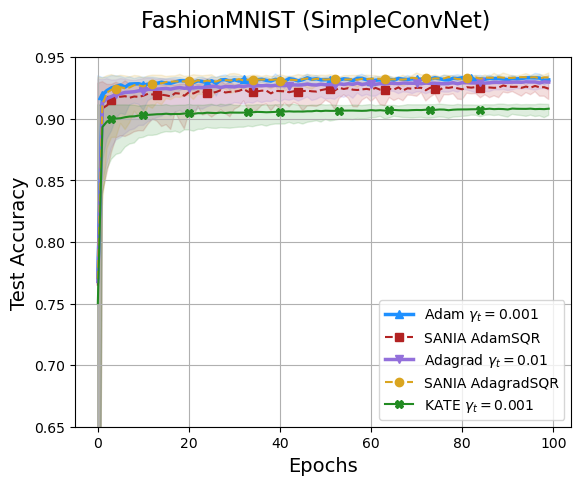

In [138]:
dataset_name = "FashionMNIST"
model_name = "SimpleConvNet"
batch_size = 128
n_epochs = 100

methods = ["Adam", "SANIA_AdamSQR", "Adagrad", "SANIA_AdagradSQR", "KATE"]
lrs = [0.001, 1.0, 0.01, 1.0, 0.001]
colors = ["dodgerblue", "firebrick", "mediumpurple", "goldenrod", "forestgreen"]
linestyles = ["-", "--", "-", "--", "-"]
linewidths = [2.5, 1.5, 2.5, 1.5, 1.5]
markers = ["^", "s", "v", "o", "X"]
labels = [r"Adam $\gamma_t = 0.001$", "SANIA AdamSQR", r"Adagrad $\gamma_t = 0.01$", "SANIA AdagradSQR", r"KATE $\gamma_t = 0.001$"]

scales = [0, 0, 0, 0, 0]


# plot_all(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         postfix="acc", ylim=[[0.0, 0.4], [0.15, 0.4], [0.85, 1.01]],
#         threshold=0.0, tight_layout=True, 
#         filename=f"all_metrics_{dataset_name}_{model_name}_{batch_size}.pdf"
#         )


plot_acc(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales,
        labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
        prefix="test/epoch/acc", ylim=[0.65, 0.95], ylabel="Test Accuracy",
        threshold=0.0, tight_layout=False, 
        filename=f"{dataset_name}_{model_name}_{batch_size}.pdf"
        )

/home/farshed.abdukhakimov/projects/SANIA/experiments/plots/28-11-2024/all_metrics_CIFAR10_DenseNet121_256.pdf


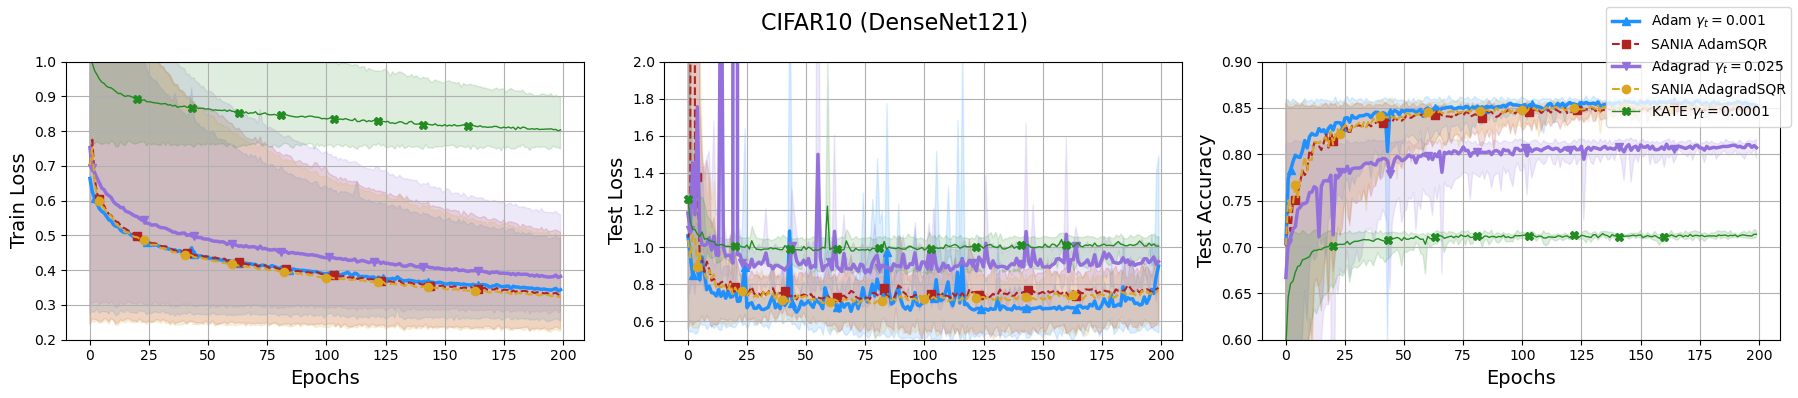

In [151]:
dataset_name = "CIFAR10"
model_name = "DenseNet121"
batch_size = 256
n_epochs = 200

methods = ["Adam", "SANIA_AdamSQR", "Adagrad", "SANIA_AdagradSQR", "KATE"]
lrs = [0.001, 1.0, 0.025, 1.0, 0.0001]
colors = ["dodgerblue", "firebrick", "mediumpurple", "goldenrod", "forestgreen"]
linestyles = ["-", "--", "-", "--", "-"]
linewidths = [2.5, 1.5, 2.5, 1.5, 1,5]
markers = ["^", "s", "v", "o", "X"]
labels = [r"Adam $\gamma_t = 0.001$", "SANIA AdamSQR", r"Adagrad $\gamma_t = 0.025$", "SANIA AdagradSQR", r"KATE $\gamma_t = 0.0001$"]

scales = [0, 0, 0, 0, 0]

plot_all(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales,
        labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
        postfix="acc", ylim=[[0.2, 1.0], [0.5, 2.0], [0.60, 0.9]],
        threshold=0.0, tight_layout=True, 
        filename=f"all_metrics_{dataset_name}_{model_name}_{batch_size}.pdf"
        )


# plot_acc(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         prefix="test/epoch/acc", ylim=[0.55, 0.95], ylabel="Test Accuracy",
#         threshold=0.0, tight_layout=False, 
#         filename=f"{dataset_name}_{model_name}_{batch_size}.pdf",
#         )

/home/farshed.abdukhakimov/projects/SANIA/experiments/plots/22-11-2024/SVHN_ShuffleNetV2x0_5_256.pdf


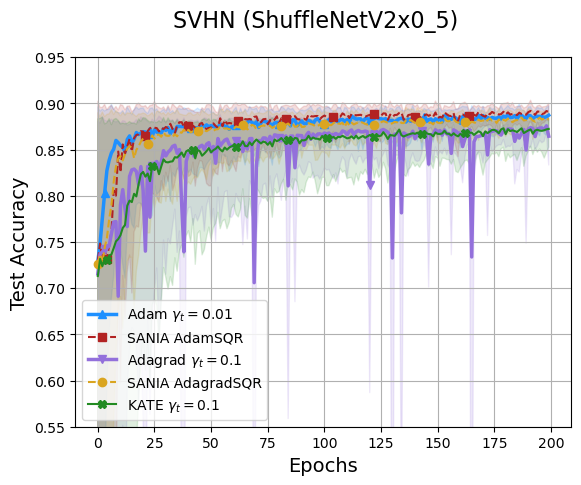

In [140]:
dataset_name = "SVHN"
model_name = "ShuffleNetV2x0_5"
batch_size = 256
n_epochs = 200

methods = ["Adam", "SANIA_AdamSQR", "Adagrad", "SANIA_AdagradSQR", "KATE"]
lrs = [0.01, 1.0, 0.1, 1.0, 0.1]
colors = ["dodgerblue", "firebrick", "mediumpurple", "goldenrod", "forestgreen"]
linestyles = ["-", "--", "-", "--", "-"]
linewidths = [2.5, 1.5, 2.5, 1.5, 1.5]
markers = ["^", "s", "v", "o", "X"]
labels = [r"Adam $\gamma_t = 0.01$", "SANIA AdamSQR", r"Adagrad $\gamma_t = 0.1$", "SANIA AdagradSQR", r"KATE $\gamma_t = 0.1$"]

scales = [0, 0, 0, 0, 0]

# plot_all(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         postfix="acc", ylim=[[0.70, 1.5], [0.25, 1.0], [0.70, 1.01]],
#         threshold=0.0, tight_layout=True, 
#         filename=f"all_metrics_{dataset_name}_{model_name}_{batch_size}.pdf"
#         )

plot_acc(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales,
        labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
        prefix="test/epoch/acc", ylim=[0.55, 0.95], ylabel="Test Accuracy",
        threshold=0.0, tight_layout=False, 
        filename=f"{dataset_name}_{model_name}_{batch_size}.pdf",
        )

/home/farshed.abdukhakimov/projects/SANIA/experiments/plots/28-11-2024/all_metrics_CIFAR100_ResNet18_256.pdf


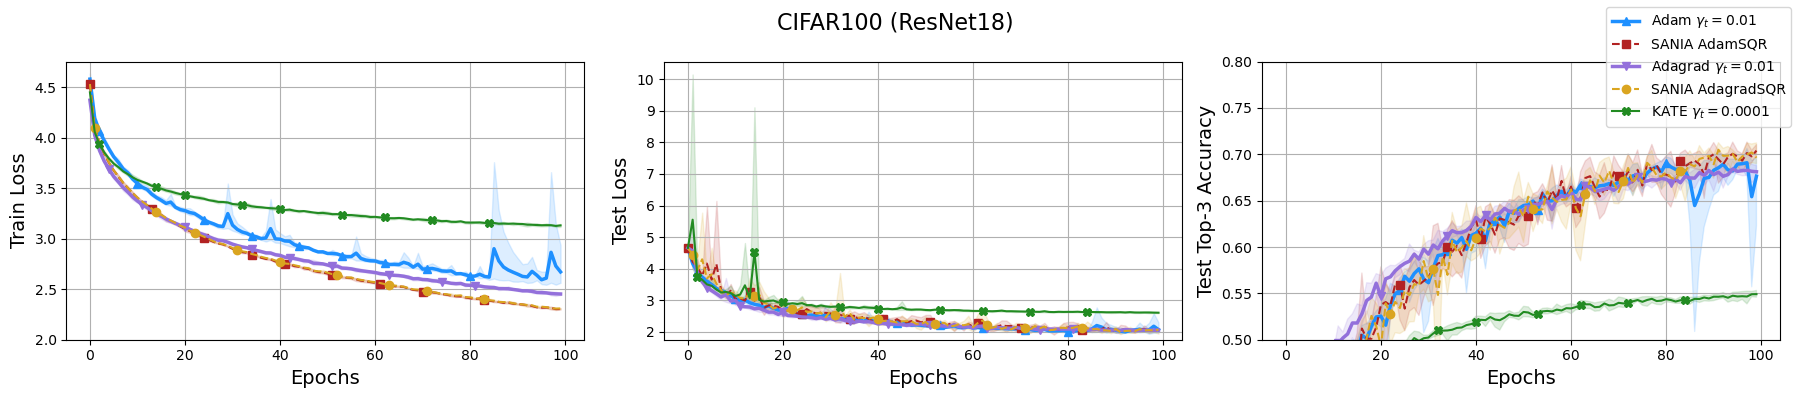

In [148]:
dataset_name = "CIFAR100"
model_name = "ResNet18"
batch_size = 256
n_epochs = 100

methods = ["Adam", "SANIA_AdamSQR", "Adagrad", "SANIA_AdagradSQR", "KATE"]
lrs = [0.01, 1.0, 0.01, 1.0, 0.0001]
colors = ["dodgerblue", "firebrick", "mediumpurple", "goldenrod", "forestgreen"]
linestyles = ["-", "--", "-", "--", "-"]
linewidths = [2.5, 1.5, 2.5, 1.5, 1.5]
markers = ["^", "s", "v", "o", "X"]
labels = [r"Adam $\gamma_t = 0.01$", "SANIA AdamSQR", r"Adagrad $\gamma_t = 0.01$", "SANIA AdagradSQR", r"KATE $\gamma_t = 0.0001$"]

scales = [0, 0, 0, 0, 0]

plot_all(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales,
        labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
        postfix="top3_acc", ylim=[[2.0, None], [1.75, None], [0.5, 0.8]],
        threshold=0.0, tight_layout=True, seeds=4, 
        filename=f"all_metrics_{dataset_name}_{model_name}_{batch_size}.pdf"
        )

# plot_acc(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
#         methods=methods, lrs=lrs, scales=scales,
#         labels=labels, colors=colors, linestyles=linestyles, 
#         linewidths=linewidths, markers=markers, suptitle=f"{dataset_name} ({model_name})", 
#         prefix="test/epoch/top3_acc", ylim=[0.3, 0.8], ylabel="Test Top-3 Accuracy",
#         threshold=0.0, tight_layout=False, 
#         seeds=4,
#         filename=f"{dataset_name}_{model_name}_{batch_size}.pdf",
#         )